<h1 style="text-align: center;">
<span style= 'color : #f31567'> Analytic Model for Light Yield Estimation version 2.0 </span> 
<!-- <span style= 'color : #f31567'> Analytic Model for Estimating Light Collection Efficiency Version 2.0 </span>  -->
</h1>
<hr>
<br>
<p style='color : #FFAA00;  font-size: 16pt; font-family:courier;'>
    Story so far.. :
<span style= 'color : silver; text-align: center; '> This notebook is written to implement Segreto model.
    <ol>
       <li> It has the provision to include the Rayleigh scattering and absorption. ✅</li> 
       <li> renamed few variables to be compliant with Segreto's paper. ✅</li>
       <li> I will add additional terms later for the configuration where even SiPM are covered with WLS. </li>
       <li> default value Q_vis = 1</li>
        <li> default value Q_vuv = 1</li>
        <li> default value $\epsilon_{wls} = 1 $</li>
        <li> deafault value SY=40</li>
        <li> </li>
        <li> </li>
    </ol>

</span> 
</p>
<p style ='color:red; '> Note:
</p>
<p style = 'color:yellow'>
     one important thing to note is that current modification only work when there is no WLS coating on the Photon Detection Device,i.e, SiPM

</p>

<span style = 'color:tomato'> 
    Relevant Documentation: 
<a href="https://www.overleaf.com/read/vpkvkgpfqwst">https://www.overleaf.com/read/vpkvkgpfqwst</a>
    
</span>
</p>


$$
LCE = \frac{X}{1-(s+w)} 
$$
<br>
$$ LCE = \frac{f_{sen}FF_{sys}(1-R)}{1-( f_{sen}R + (1-f_{sen})R_{wall} )} $$
<br>

<p style= "text-align: center;">
<br>
 <p style= "text-align: center;">
<span style = 'color:tomato;'> 
    Relevant Documentations: 
<a href="https://arxiv.org/pdf/1110.6370.pdf">Segreto 2012</a>    
</span>
<p style= "text-align: center;">
<br>
<span style = 'color:tomato'> 
    Research Notes: 
<a href="https://docs.google.com/document/d/1k-8OMUld0fGFGO-Om6wp_pJkQwOL-QxgrfYoKsZIPF4/edit">Google Docs link </a>
    
</span>
</p>

In [1]:
from os import path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
%matplotlib inline
# %matplotlib qt

<h2 style = 'color:#66AAEE; font-size: 20pt; text-align: center;'>
    Data loading & Pre-processing
</h2>

<p style ='color: silver; font-size: 14pt'> project directory is defined in the following cell; it will remain same through out the notebook.
</p>
<p style ='color: silver; font-size: 14pt'>PS:  The preprocessing is different for each file depending on data structure.
</p>

<h3 > ✏ <span style = 'color: #7bc5ef; '> Project Directory </span>
</h3>

In [2]:
### define project directory
project_dir = r'C:\Users\sarth\projects\LY_Analytic_Model'; 

<h3 style = 'text-align: left;  color:magenta; font-family: courier prime; font-size:16pt;'>
     SiPM Reflectance data
</h3>
<!-- <p>
    SiPM Reflectance .dat file provided by Cenk
    <br>
    <span style = 'color: #FF6611; font-size: 18px'> Note: </span> 
    SiPM Reflectance is multiplied by 0.91 to take care of the effect of antireflective coating in Liquid Argon chamber (needs further investigtation)
</p> -->

In [3]:
R_SiPM_df = pd.read_csv(path.join(project_dir, 'Data','sipm_hr1_processed.txt'), sep = '\t')  ## 'Data' is the name of the folder containing Data files
R_SiPM = R_SiPM_df.copy()
R_SiPM['R'] = [int(value)/100 for value in R_SiPM_df['R']]

## cenk's data files for darkside veto are given below

# cenk_SiPM_R_df = pd.read_csv(path.join(project_dir, 'Data','SiPM_ref.csv'), sep = ',')
# # cenk_SiPM_R_values = cenk_SiPM_R_vector.copy()
# # cenk_R_SiPM_values['R'] = [int(value)/100 for value in cenk_R_SiPM_vector['R']]
# cenk_SiPM_R_df2 = cenk_SiPM_R_df.copy()
# cenk_SiPM_R_df2['LAr_equivalent_Reflectance'] = cenk_SiPM_R_df2['R']*0.91 

# ### Note: SiPM is coated with an unknown anti-reflection coating
# ### 0.91 : To get the unknown reflectivity of SiPM in Liquid Argon. Since SiPM is also coated with an anti reflection coating, getting the equivalent 
# ### reflectance is not straight forward. 0.91 is based on an educated guess.

# cenk_SiPM_R_df2['wavelength'] = 1239.847/cenk_SiPM_R_df2['E'] # Eneergy unit eV wavlength Unit: nm
# # SiPM_ref.dat
# # cenk_SiPM_R_df3 = cenk_SiPM_R_df2.sort_values(by = 'wavelength')

In [4]:
# cenk_SiPM_R_df2.head()

In [5]:
# plt.figure()
# plt.plot(cenk_SiPM_R_df2['wavelength'], cenk_SiPM_R_df2['R'])
# plt.plot(SiPM_R_values['Wavelength'], SiPM_R_values['R'])

<h3 style = 'text-align: left;  color:magenta; font-family: courier prime; font-size:16pt;'> 
    SiPM PDE data
</h3>
<p>
    Caustion : when using FBK PDE values, normalize with 40/52.77
</p>

In [6]:
### FBK Values sent by cenk
# photon_wavelegnth = [285.87, 301.14, 320.99, 340.83, 365.26, 380.53, 391.22, 400.38, 411.06, 420.22, 435.49, 449.23, 464.50, 499.61, 588.16, 698.09]
# PDE_vector = [18.39, 37.24, 41.87, 42.43, 45.03, 48.12, 52.72, 52.75, 52.77, 52.29, 48.77, 46.26, 40.71, 38.76, 28.82, 18.93] # %age values
# PDE_normalized_vector = []
### Normalizing PDE values in FBK data as instructed by Cenk
# PDE_normalized_vector = [value*40/max(PDE_vector) for value in PDE_vector]
## PDE_normalized_vector
# norm_PDE_values = [value/100 for value in PDE_normalized_vector]

### LFoundry PDE Values sent by Cenk
photon_wavelegnth = [365.39, 390.34, 399.89, 409.98, 420.06, 434.93, 450.32, 500.21, 525.16, 545.33, 590.98, 630.25, 700.32]
PDE_vector = [43.277, 51.892, 54.257, 52.399, 50.709, 46.993, 42.601, 36.014, 30.439, 28.581, 24.358, 20.473, 15.574]
# Normalization for PDE values 
norm_PDE_values = [value/100 for value in PDE_vector]


frame = {'photon_wavelegnth':photon_wavelegnth, 'PDE_norm': norm_PDE_values}

PDE = pd.DataFrame(frame)

# max(PDE['PDE_norm'])

<h3 style = 'text-align: left;  color:magenta; font-family: courier prime; font-size:16pt;'>
   PEN Reflectance Data 
</h3>
<!-- <p>
<span style= 'color: red; font-size : 22px'>  Needs verification !!! 
</span>
</p> -->

In [7]:
## R_wall_PEN = 
PEN_photon_energy = [0.1, 2.067,2.175,2.214,2.255,2.340,2.385,2.431,2.436,2.531,2.583,2.638,2.696,2.725,2.756,2.787,2.818,
2.884,2.918,2.952,2.988,3.024,3.039,3.047,3.054,3.062,3.069,3.077,3.085,3.092,3.100,3.108,3.116,3.123,3.131,3.139,3.147,3.155,
3.163,3.171,3.179,3.188,3.196,3.204,3.212,3.221,3.263, 8.0] ## energy in eV

PEN_reflectance = [100.130, 100.130,99.995,99.856,99.681,99.659,99.569,99.351,99.306,99.018,98.652,98.415,98.283,
98.018,97.856,97.606,97.457,97.134,96.928,96.827,96.247,95.737,95.359,95.197,95.048,94.876,94.684,94.463,94.055,93.650,93.147,
92.562,91.812,90.904,89.807,88.506,86.957,85.242,83.156,80.678,77.811,74.615,71.004,67.089,62.924,58.670,20.000, 20.000] ## %age reflectance

# PEN_reflectance = [reflectance*0.98/100 for reflectance in PEN_reflectance] 
PEN_reflectance = [reflectance*0.98*0.994/100 for reflectance in PEN_reflectance] 

### Reflectance is multiplied by 0.98 and 0.994 for calibration purpose:
    ### 1. 0.98 is the reflectance of Basrium Sulphate used as the standard in photo spectrometer
    ### 2. The second factor is specific to 2PAC. 0.994 is the coverage fraction of Wavelength Shifting material (a small surface coverage is lost to holes, bolts etc in 2PAC)
### The calculation is very senstitive to Reflectance


photon_wavelength = []

for energy_value in PEN_photon_energy:
    wavelength_value = 1239.847/energy_value
    photon_wavelength.append(wavelength_value)

frame = {'photon_wavelength': photon_wavelength,
        'PEN_reflectance': PEN_reflectance}

R_Wall_PEN = pd.DataFrame(frame)

## reverse the order of wavelength smaller to bigger
R_Wall_PEN = R_Wall_PEN.iloc[::-1]

# R_Wall_PEN

<h3 style = 'text-align: left;  color:magenta; font-family: courier prime; font-size:16pt;'> PEN Emission Spectrum </h3>

In [8]:
# r_PEN = r'D:\D Downloads\Current_work\pen-tess.txt'
r_PEN = path.join(project_dir, 'Data', 'pen-tess.txt')
emission_spectrum_PEN = pd.read_csv(r_PEN, sep ='\t')

E_PEN = emission_spectrum_PEN.drop(['a','b','c'], axis=1)

# E_PEN

# normalize : divide by maximum value
E_PEN['efficiency'] = E_PEN['efficiency']/max(E_PEN['efficiency'] ) 

# remove negative values
E_PEN = E_PEN[E_PEN > 0].dropna()
# E_PEN['efficiency']
## What are the units of efficiency? Normalize PEN Spectrum ??
## Remove negative values?
## Need linear interpolation for everyuthing R, R_Wall, PDE and emission spectrum

<h3 style = 'text-align: left;  color:magenta; font-family: courier prime; font-size:16pt;'> TPB Reflectance data 
</h3>

In [9]:
TPB_photon_energy = [0.1, 2.067,2.175,2.214,2.255,2.340,2.385,2.431,2.436,2.531,2.583,2.638,2.696,2.725,2.756,2.787,2.818,2.884,2.918,2.952,2.988,3.024, 3.221,3.263, 8.0]
TPB_reflectance = [98.936,98.936,99.180,99.309,99.375,99.392,99.534,99.490,99.491,99.685,99.635,99.593,99.541,99.457,99.380,99.374,99.196,98.924,98.521,97.653,95.581,92.569,13.0,3.0,3.0]

photon_wavelength = []

# TPB_reflectance = [reflectance*0.98/100 for reflectance in TPB_reflectance]
TPB_reflectance = [reflectance*0.98*0.994/100 for reflectance in TPB_reflectance]

### Reflectance is multiplied by 0.98 and 0.994 for calibration purpose:
    ### 1. 0.98 is the reflectance of Basrium Sulphate used as the standard in photo spectrometer
    ### 2. The second factor is specific to 2PAC. 0.994 is the coverage fraction of Wavelength Shifting material (a small surface coverage is lost to holes, bolts etc in 2PAC)
### The calculation is very senstitive to Reflectance

for energy_value in TPB_photon_energy:
    wavelength_value = 1239.847/energy_value
    photon_wavelength.append(wavelength_value)

frame = {'photon_wavelength': photon_wavelength,
        'TPB_reflectance': TPB_reflectance}

R_Wall_TPB = pd.DataFrame(frame)

## reverse the order of wavelength smaller to bigger
R_Wall_TPB = R_Wall_TPB.iloc[::-1]

# R_Wall_TPB

<h3 style = 'text-align: left;  color:magenta; font-family: courier prime; font-size:16pt'> TPB Emission Spectrum </h3>

In [10]:
#### why do we have negative values?
#### Might need to clean data
## drop negative values
## normalize efficiency

# r_TPB = r'D:\D Downloads\Current_work\tpb-fran.txt'
r_TPB = path.join(project_dir, 'Data','tpb-fran.txt')
emission_spectrum_TPB = pd.read_csv(r_TPB, sep ='\t')

E_TPB = emission_spectrum_TPB.drop(['a','b','c','d'], axis=1)
# E_TPB

<p style = 'color:slate'> Click here to see a warning </p>
<!-- Warning: TPB data has negative values -->

In [11]:
# normalize : divide by maximum value
E_TPB['efficiency'] = E_TPB['efficiency']/max(E_TPB['efficiency'] ) 
# remove negative values
E_TPB = E_TPB[E_TPB > 0].dropna()

# E_TPB


<h3 style = 'color:deeppink'> Smoothing function </h3>

In [12]:
### variable name 'photon_wavelegnth' is NOT hard coded for all the data frames.
def make_smooth(data_frame_var):
    name_column_0 = data_frame_var.columns[0]
    name_column_1 = data_frame_var.columns[1]
    
    photon_wavelength = data_frame_var[name_column_0]
    physical_quantity = data_frame_var[name_column_1]
    
    interpol_func = interp1d(photon_wavelength , physical_quantity)
    return  interpol_func(wavelength_vector)

<h3> 
✏ <b style = "font-size:18pt; font-family: courier prime; color: #7bc5ef;"> Define Wavelength range </b>

</h3>
<br>
<p style = 'color:silver'>
    wavelength_vector is common throughout the notebook.
</p>

In [13]:
wavelength_vector = np.arange(366, 560, 0.5)  ### do we want to hard code wavelength range?

In [14]:
### call smoothing functions here
R_SiPM_smooth = make_smooth(R_SiPM)

R_Wall_PEN_smooth = make_smooth(R_Wall_PEN)

R_Wall_TPB_smooth = make_smooth(R_Wall_TPB)

PDE_smooth = make_smooth(PDE)

E_PEN_smooth = make_smooth(E_PEN)

E_TPB_smooth = make_smooth(E_TPB)   

<h2 style= 'text-align: center;'>
    <span style  = 'color: gold'> Wavelength integrated LY with Absorbtion and Rayleigh Scattering effects</span>
</h2>

<h3 style = 'color: DeepPink '> calculating $Q$ factor
</h3>

In [15]:
from sympy import Symbol, exp, integrate

x = Symbol('x')

## L_char is basically what L tilde is in segreto paper

## lambda_eff is basically lambda tilde in segreto paper

def calc_lambda_eff(lambda_abs, lambda_R):
    ''' Calculates effective lambda for Rayleigh scattering and Absorption.
    Haven't decided on unit of length: cm or m?
    '''
    return (lambda_R*lambda_abs)/(lambda_R + lambda_abs)

def P_func(L_char, lambda_eff):
    ''' 
    P_func: P(x) is the probability distribution of the distances that a photon would travel in absence of interactions (between two reflections or between a reflection and absorption/detection).
    The P_func can be changed later if it is felt that we need a different probability distribution function. 
    '''
    return 1/(L_char)

def calc_URA(L_char, lambda_eff, Prob_distr):
    return integrate( Prob_distr*exp(-x/lambda_eff), (x, 0, L_char))

def calc_Q( L_char,  lambda_abs, lambda_R):
    ''' 
    This function is used to compute Q factor for both visible and VUV photons.
    Note:
    We'll call calc_URA since URA is wavelength dependent. We'll also make a call to P_func so for the same reason.
    '''
    lambda_eff = calc_lambda_eff(lambda_abs, lambda_R)
    
    Pdf = P_func(L_char, lambda_eff); # Probability distribution function
    
    URA_value = float(calc_URA(L_char, lambda_eff, Pdf));
    
    return (1-(1-URA_value)*lambda_eff/lambda_R)/(URA_value)

<p style = 'color:lime; font-size:14pt'>
$$ L\_char = 6\times \frac{volome}{surface\_area}
$$
</p>

<h3 style = 'color:DeepPink;'>  Calculating $F $
</h3>

<span style = 'color : lime;'>

$$ F( Q, f_{sen}FF_{sys}(1-R), f_{sen}R + (1-f_{sen} )R_{wall} ) = \frac{f_{sen}FF_{sys}(1-\color{Red}R)}{\color{Red}Q-( f_{sen}\color{Red}R + (1-f_{sen})\color{Red}{R_{wall}} )} $$

</span>

<span style = 'color : lime;'>

$$ F(Q,X, s + w) = \frac{X}{Q-(s+w)} $$

</span>

In [16]:
def calc_F(R, R_wall, f_sen, FF_sys, Q_value):    
    '''
    R, R_wall are all wavelength dependent. Q_value is provided as an argument.
    '''
    return (f_sen*FF_sys*(1-R))/(Q_value - (f_sen*R + (1-f_sen)*R_wall) )

<h3 style = 'color: DeepPink '> Calculating Light Collection Efficiency, $LCE$
</h3>

<br>
<span style = 'color:lime; font-size:12pt;'> 
    $$
    LCE = \frac{(1-f_{sen})*\epsilon_{wls}*\color{Red}{F(Q_{vis}, X, s+w)}}{Q_{VUV}}
    $$
</span>
<br>

In [17]:
def calc_LCE(R, R_wall, f_sen, FF_sys, wls_eff, Q_vuv=1, Q_vis=1):
    ''' calc_LCE requires Q_vis and Q_vuv values as arguments. Both are set at default value of 1.
    Though Absorption and Rayleigh scattering lengths will be dependent on wavelength,
    currently we don't have accurate meansurements of these values for different wavelengths.
    Hence we will be using an average value for entire visible spectrum and another value for VUV (remember VUV photon has a single wavelength).
    In case accurate values of absorption and scattering lengths become available I will need to modify the Q_vis accordingly.
    Side note: Q_vis and Q_vuv are computed in the scope of function integrate_LY.
    '''
    return ((1-f_sen)*wls_eff*calc_F(R, R_wall, f_sen, FF_sys, Q_vis))/(Q_vuv)

<h3 style = 'color: DeepPink; text-align:center; font-size:24pt; '> 🍕 integrate Light Yield
</h3>
<!-- <p>
Previously known as Weighted Average of Light Yield 
</p> -->

<!-- <p> 
<span style = 'color : #5EA9E5;'> 
<br>
% $$
% integrate\_LY = \frac{\sum( [LY\_value(\color{red}{PDE(\lambda)}, f_{sen}, FF_{sys}, \color{red}{R(\lambda)}, \color{red}{R_{wall}(\lambda)}, \color{red}{Q(\lambda)}, \epsilon_{wls} ) ] * \color{red}{E_{wls}(\lambda)})}{\sum \color{red}{E_{wls}(\lambda)}}
% $$
</span>
<br>
<br>
<br>
</p> -->

<p> 
<span style = 'color : lime; font-size:14pt;'> 
<br>
<br>
$$
integrate\_LY = \frac{SY* \sum( [calc\_LCE(f_{sen}, FF_{sys}, \color{red}{R(\lambda)}, \color{red}{R_{wall}(\lambda)}, \color{red}{Q(\lambda)}, \epsilon_{wls}) ] * [ \color{red}{PDE(\lambda)} ] * [ \color{red}{E_{wls}(\lambda)} ] ) } {\sum \color{red}{E_{wls}(\lambda)}}
$$
</span>
<br>
<br>
<span style= ' font-size:14pt; text-align: left; color:white;'>
PS: Red --> wavelength dependent
<br>
    $E_{wls}$ is the emission spectrum of wavelength shifter.
<br>
    $\epsilon_{wls}$ is the wavelength shifting efficiency. See variable wls_eff
</span>
</p>

In [18]:
# def integrate_LY(wavelength_range, WLS_emission_spectrum, PDE_smooth, R, R_wall, f_sen, FF_sys, SY=40): 
### think of a way so that we don't have to specify wavelength_vector from outside
def integrate_LY(wavelength_vector, WLS_emission_spectrum, PDE_smooth, R, R_wall, f_sen, FF_sys, wls_eff = 1.0, SY=40):
    '''
    wavelength_vector is defined outside this function. 
    𝜖_𝑤𝑙𝑠 represents the wavelength shifting efficiency of the WaveLength Shifter assigned to variable wls_eff.
    '''
    # wavelength_vector = np.arange(wavelength_range[0], wavelength_range[1], wavelength_range[2])
    # wls_eff = 1.0
    
    numerator_value = 0 ;
    denominator_value = 0 ;
    
    ### lambda R and abs values provided by Marcin
    # Q_vis = calc_Q(L_char=1, lambda_abs=100, lambda_R=300) 
    # Q_vuv = calc_Q(L_char=1, lambda_abs=17, lambda_R=0.97)
    ### in case where we use average values of lambda_abs & lambda_R for entire visible range
    
    # default values when we are ignoting Absorption and Rayleigh scattering effect
    Q_vuv = 1; 
    Q_vis = 1;
    
    for wavelength_index in range(len(wavelength_vector)):
        numerator_value += calc_LCE(R[wavelength_index], R_wall[wavelength_index], f_sen, FF_sys, wls_eff, Q_vis, Q_vuv) * PDE_smooth[wavelength_index] * WLS_emission_spectrum[wavelength_index];
    denominator_value = sum(WLS_emission_spectrum)
    return SY*numerator_value/denominator_value

<h5 style = 'color: RED; font-size: 14pt'> Notes: </h5>
<p> Everything has been confirmed till this point for default case where Q=1. </p>

<h2 style = 'color: #11EEAA; font-family: courier prime; font-size:28pt; text-align: center'> Application... </h2>
<p style = 'color: orange'> we'll apply this model to different configuration of detectors and estimate their performance. 
<br>
Perhaps we should start with Dark Side veto since Cenk has already worked on it so we'll have his monte carlo simulations to compare with.
</p>

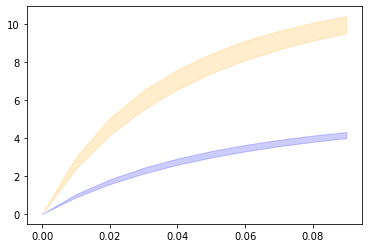

In [19]:
### To be implemented to darkside veto
### find characteristic length for dark side veto 
f_sen_vector = np.arange(0, 0.1, 0.01)
LY_PEN_upper = 0.472*integrate_LY(wavelength_vector, E_PEN_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_PEN_smooth, f_sen_vector, 1)
LY_PEN_lower = 0.472*integrate_LY(wavelength_vector, E_PEN_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_PEN_smooth*0.988, f_sen_vector, 1)
plt.fill_between( f_sen_vector, LY_PEN_lower,  LY_PEN_upper, color='blue', alpha=0.2, label='PEN' )

LY_TPB_upper = integrate_LY(wavelength_vector, E_TPB_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_TPB_smooth, f_sen_vector, 1)
LY_TPB_lower = integrate_LY(wavelength_vector, E_TPB_smooth, PDE_smooth, R_SiPM_smooth, R_Wall_TPB_smooth*0.988, f_sen_vector, 1)
plt.fill_between( f_sen_vector, LY_TPB_lower,  LY_TPB_upper, color='orange', alpha=0.2, label='TPB' )